# Local 개발 코드
- 로컬에서 주피터 노트북(Jupyter Notebook) 또는 파이썬(Python)을 이용한다.
- 텐서플로우(tensorflow), 파이토치(pytorch)를 사용하여 프로그램을 개발한다.
- 파일명 : 0_local.ipynb

# Local 개발 워크플로우(workflow)
- 로컬 개발 워크플로우를 다음의 4단계로 분리한다.

1. 데이터셋 준비(Data Setup)
- 로컬 저장소에서 전처리 및 학습에 필요한 학습 데이터셋을 준비한다.

2. 데이터 전처리(Data Preprocessing)
- 비디오, 오디오, 텍스트 데이터에 대해 백본을 통해 feature extract를 진행하기 위한 전처리를 수행하고 이를 통해 proj_head에 필요한 feature vector를 추출한다.
- 추론과정에서 텍스트 데이터의 경우, data 하위 폴더의 json 파일에서 video_data에 대한 정보를 받아온다.

3. 학습 모델 훈련(Train Model)
- Common project space에서 proj_head를 학습하기 위해 Torch를 이용하여 모델을 구축하고자 한다.
- 학습 모델을 준비된 데이터셋으로 훈련시킨다.
- 손실(Loss)로 학습 모델의 성능을 검증한다.
- 학습 모델의 성능 검증 후, 학습 모델을 배포한다.
- 배포할 학습 모델을 save_model 폴더에 저장한다.

4. 추론(Inference)
- 훈련시킨 모델을 통해 순위를 매겨 사용자에게 제공하고자 한다. SceneDetection을 통해 비디오, 오디오 특징 벡터를 추출하고 사용자의 query를 받아 텍스트 특징 벡터를 추출하여 MMV 모델을 통해 사용자의 쿼리를 고려한 영상의 인덱스를 순위로 반환하여 준다.
- 실험 결과를 통해 비디오-오디오는 영향이 적어 비디오-텍스트의 유사도만 반영

# 비디오 검색 (Video Retrival)

## 0. Dataset

### QVGHIGHLIGHTS 

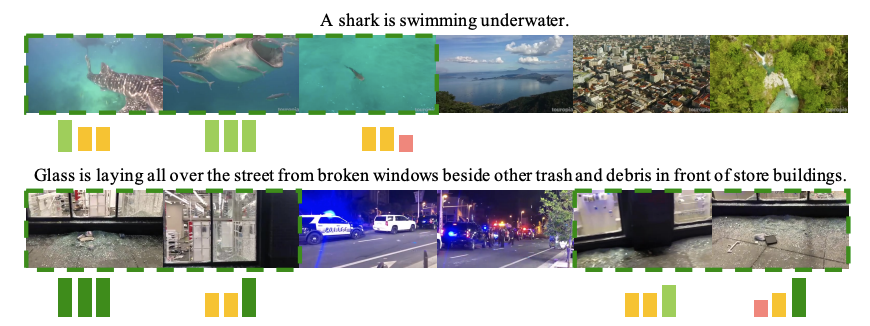




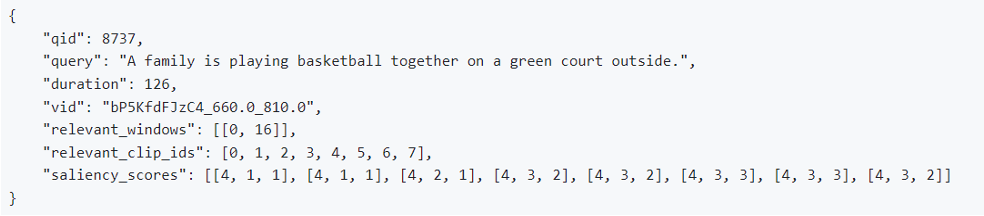

Detecting Moments and Highlights
in Videos via Natural Language Queries 논문에서 제공하는 Open Dataset인 QVGHIGHLIGHTS이라는 데이터셋으로 비디오와 비디오 장면의 상황적 특징을 설명하는 텍스트가 짝을 지어 연결되어 annotation되어 이으므로, MMV multimodal proj_head를 학습시키기에 적합하다고 판단되어 사용
- Query : 10,310
- Video : 10,148
- Moment : 18,367
- Category : 일상 블로그, 여행 블로그, 뉴스 이벤트 등

In [2]:
import os
import numpy as np

In [1]:
import torch as th

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import SequentialSampler

In [5]:
import tensorflow.compat.v2 as tf
import tensorflow_io as tfio
import tensorflow_hub as hub

2023-07-11 02:04:45.230273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
import sklearn
from sklearn.preprocessing import MaxAbsScaler

In [7]:
from moviepy.editor import VideoFileClip
import soundfile as sf
import json
import tqdm
from tqdm import notebook
import random
import pathlib
import itertools
import collections
import soundfile as sf
import re
import time
import gensim
from gensim.models.keyedvectors import KeyedVectors
import gc

In [8]:
import cv2
import remotezip as rz
from nltk.corpus import stopwords #불용어 제거
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize # 토큰화 모듈
import re
import time
from transformers import AutoTokenizer
import nltk  # 불용어 처리

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/bsw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bsw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. 데이터셋 준비(Data Setup)

In [9]:
# Audio Converter
# raw video에서 raw audio를 추출하는 함수
def convert_video_to_audio(mp4_file, wav_file):
    video = VideoFileClip(mp4_file)
    audio = video.audio
    audio.write_audio_file(wav_file)


def converter(Video_file_name, video_path, audio_path):
    for i in Video_file_name:
        mp4_file = video_path + '/' + i + '.mp4'
        wav_file = audio_path + '/' + i + '.wav'
        convert_video_to_audio(mp4_file, wav_file)

In [10]:
# Load Dataset Information
# 데이터셋의 video id와 query 정보를 json 파일로 저장하는 함수
def use_qvhighlights(name_path, name_query_path, file_path, mini_batch_size):
    # 전체 JSONL 파일 읽기
    file_name = []
    file_query = []

    # video 정보가 들어있는 json 파일을 load
    # video id와 query만 불러오기
    for path in file_path:
        data_name = []

        with open(path, 'r') as file:
            for line in file:
                json_obj = json.loads(line)
                data_name.append(json_obj)

        for i in range(len(data_name)):
            file_name.append(data_name[i]['vid'])
            file_query.append(data_name[i]['query'])
    
    # video id 저장하는 리스트
    # video query 저장하는 리스트
    Video_file_name = file_name
    Video_file_query = file_query

    # mini batch 단위로 save
    for i in range((len(Video_file_name)//mini_batch_size)+1):
        mini_batch_name = []
        mini_batch_query = []
        mini_batch_name_query = []

        for j in range(i*mini_batch_size, (i+1)*mini_batch_size):
            if j>=len(Video_file_name): break
            mini_batch_name.append(Video_file_name[j])
            mini_batch_query.append(Video_file_query[j])

            # video id 저장
            with open(name_path.format(i), 'w') as json_file:
                json.dump(mini_batch_name, json_file)

            # video query 저장
            for name, query in zip(Video_file_name, Video_file_query):
                vid_query = {'vid': name, 'query': query}
                mini_batch_name_query.append(vid_query)

            with open(name_query_path.format(i), 'w') as json_file:
                json.dump(mini_batch_name_query, json_file)

        print('{n} / {range}'.format(n=i+1, range=(len(Video_file_name)//mini_batch_size)+1))

    return Video_file_name

## 2. 데이터 전처리 (Data Preprocessing)

### (1) Video

- MMV 논문에서 제안한 Proj_head에 들어갈 input_data의 데이터 전처리를 진행한다.
- qvhighlights dataset의 raw video
- MMV module을 불러와 preprocessing을 진행

In [23]:
class video_embedding:
    def __init__(self, video_path, T_v, H, W, batch_size, mode=None):
        self.video_path = video_path
        self.T_v = T_v
        self.H = H
        self.W = W
        self.batch_size = batch_size
        self.mode = mode
        

    # video를 frame단위로 전처리
    def format_frames(self, frame, output_size):
        frame = tf.image.convert_image_dtype(frame, tf.float32)
        frame = tf.image.resize_with_pad(frame, *output_size)
        return frame


    # video 파일에서 입력 frame 단위로 추출
    def frames_from_video_file(self, video_path, n_frames, frame_step=15):
        result = []

        src = cv2.VideoCapture(str(video_path))

        video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

        need_length = 1 + (n_frames - 1) * frame_step

        # video 별 scene detection한 정보
        # -------------------------------------------------------------------
        if need_length > video_length:
            start = 0
        else:
            max_start = video_length - need_length
            start = random.randint(0, max_start + 1)
        #---------------------------------------------------------------------

        output_size=(self.H, self.W)

        src.set(cv2.CAP_PROP_POS_FRAMES, start)
        ret, frame = src.read()
        result.append(self.format_frames(frame, output_size))

        for _ in range(n_frames - 1):
            for _ in range(frame_step):
                ret, frame = src.read()
            if ret:
                frame = self.format_frames(frame, output_size)
                result.append(frame)
            else:
                result.append(np.zeros_like(result[0]))
        src.release()
        result = np.array(result)[..., [2, 1, 0]]

        return result


    # video feature를 추출하는 함수
    def extract(self, Video_file_name, name_path, before_head_video, module, Raw_Video_file_name=None):
        # MMV를 위한 feature extract
        if self.mode == 'MMV':
            Video_file = Video_file_name

            for i in range(len(Video_file)//self.batch_size): # batch_size 단위로 저장
                Video_file_name_json = open(name_path.format(i))
                Video_file_name = json.load(Video_file_name_json)
                del Video_file_name_json

                input_frame = [] # 빈 리스트로 초기화

                for j in Video_file_name:
                    video_file_path = self.video_path + '/' + j + '.mp4'
                    frames = self.frames_from_video_file(video_file_path, n_frames=self.T_v)
                    frames = np.expand_dims(frames, axis=0)  # 차원 확장
                    input_frame.append(frames)  # 리스트에 결과 추가

                print('{n} / {range}'.format(n=i+1, range=len(Video_file)//16))


                # input_frame
                input_frame = np.concatenate(input_frame, axis=0)

                # before_head
                vision_output = module.signatures['video'](tf.constant(tf.cast(input_frame, dtype=tf.float32)))
                vision_before_head = vision_output['before_head'].numpy()
                np.save(before_head_video.format(i), vision_before_head)

                print('{n} / {range} - before_head'.format(n=i+1, range=len(Video_file)//self.batch_size))
                
        
        # Scene Detection 한 후, MMV를 위한 feature extract
        elif self.mode == 'SD_MMV':
            Video_file = Video_file_name
            
            for i in range(len(Video_file)//self.batch_size): # batch_size 단위로 저장
                Video_file_name_json = open(name_path.format(i))
                Video_file_name = json.load(Video_file_name_json)
                del Video_file_name_json

                input_frame = [] # 빈 리스트로 초기화
                
                for j in Video_file_name:
                    for raw_vid in Raw_Video_file_name:
                        if raw_vid in j:
                            RAW_VID = raw_vid
                            break
                    
                    video_file_path = self.video_path + '/' + RAW_VID + '/' + j + '.mp4'
                    frames = self.frames_from_video_file(video_file_path, n_frames=self.T_v)
                    frames = np.expand_dims(frames, axis=0)  # 차원 확장
                    input_frame.append(frames)  # 리스트에 결과 추가

                print('{n} / {range}'.format(n=i+1, range=len(Video_file)//self.batch_size))


                # input_frame
                input_frame = np.concatenate(input_frame, axis=0)

                # before_head
                vision_output = module.signatures['video'](tf.constant(tf.cast(input_frame, dtype=tf.float32)))
                vision_before_head = vision_output['before_head'].numpy()
                np.save(before_head_video.format(i), vision_before_head)

                print('{n} / {range} - before_head'.format(n=i+1, range=len(Video_file)//self.batch_size))
                

### (2) Audio

- MMV 논문에서 제안한 Proj_head에 들어갈 input_data의 데이터 전처리를 진행한다.
- qvhighlights dataset의 raw video에서 추출한 raw audio
- MMV module을 불러와 preprocessing을 진행

In [15]:
class audio_embedding(nn.Module):
    def __init__(self, audio_path, T_a, batch_size, mode=None):
        self.audio_path = audio_path
        self.T_a = T_a
        self.batch_size = batch_size
        self.mode = mode
        

    # tensor로 저장되어 있는 file을 ndarray로 변환
    def tensor_to_numpy(self, file_path, T):
        audio = tfio.audio.AudioIOTensor(file_path)
        audio_tensor = audio[:]
        audio_slice = audio_tensor.numpy()
        audio = audio_slice.reshape(audio_tensor.shape[1], audio_tensor.shape[0])

        return audio


    # audio ndarray 정규화
    def normalize_audio(self, audio):
        mas = MaxAbsScaler()
        audio = audio.reshape(-1, 1)
        mas.fit(audio)
        audio_scaled = mas.transform(audio)

        return audio_scaled


    # feature를 추출하기 전, audio ndarray 전처리
    def preprocess_audio(self, audio, T):
        # audio, sr = sf.read(audio)

        audio = self.normalize_audio(audio)

        if len(audio) < T:
            audio = np.pad(audio, (0, T - len(audio)))
        else:
            audio = audio[:T]

        # Reshape: (Batch size) x T
        audio = np.expand_dims(audio, axis=0)
        audio = audio.reshape(1, -1)

        return audio


    # audio feature를 추출
    def extract(self, Video_file_name, name_path, before_head_audio, module, Raw_Video_file_name=None):
        # MMV를 위한 feature extract
        if self.mode == 'MMV':
            Video_file = Video_file_name

            for i in range(len(Video_file)//self.batch_size): # batch_size 단위로 저장
                Video_file_name_json = open(name_path.format(i))
                Video_file_name = json.load(Video_file_name_json)
                del Video_file_name_json

                input_audio = []  # 빈 리스트로 초기화

                for j in Video_file_name:
                    audio_file_path = self.audio_path + '/' + j + '.wav'

                    audio = self.tensor_to_numpy(audio_file_path, self.T_a)
                    audio = self.normalize_audio(audio)
                    audio = self.preprocess_audio(audio, self.T_a)
                    audio = np.repeat(audio, 1, axis=0)
                    input_audio.append(audio)  # 리스트에 결과 추가

                print('{n} / {range}'.format(n=i+1, range=len(Video_file)//self.batch_size))

                # input_audio
                input_audio = np.concatenate(input_audio, axis=0)

                # before_head
                audio_output = module.signatures['audio'](tf.constant(tf.cast(input_audio, dtype=tf.float32)))
                audio_before_head = audio_output['before_head'].numpy()
                audio_vat = audio_output['vat'].numpy()
                np.save(before_head_audio.format(i), audio_before_head)

                print('{n} / {range} - before_head'.format(n=i+1, range=len(Video_file)//self.batch_size))
                
                
        # Scene Detection 한 후, MMV를 위한 feature extract
        elif self.mode == 'SD_MMV':
            Video_file = Video_file_name

            for i in range(len(Video_file)//self.batch_size): # batch_size 단위로 저장
                Video_file_name_json = open(name_path.format(i))
                Video_file_name = json.load(Video_file_name_json)
                del Video_file_name_json

                input_audio = []  # 빈 리스트로 초기화

                for j in Video_file_name:
                    for raw_vid in Raw_Video_file_name:
                        if raw_vid in j:
                            RAW_VID = raw_vid
                            break
                    
                    audio_file_path = self.audio_path + '/' + RAW_VID + '/' + j + '.wav'

                    audio = self.tensor_to_numpy(audio_file_path, self.T_a)
                    audio = self.normalize_audio(audio)
                    audio = self.preprocess_audio(audio, self.T_a)
                    audio = np.repeat(audio, 1, axis=0)
                    input_audio.append(audio)  # 리스트에 결과 추가

                print('{n} / {range}'.format(n=i+1, range=len(Video_file)//self.batch_size))

                # input_audio
                input_audio = np.concatenate(input_audio, axis=0)

                # before_head
                audio_output = module.signatures['audio'](tf.constant(tf.cast(input_audio, dtype=tf.float32)))
                audio_before_head = audio_output['before_head'].numpy()
                audio_vat = audio_output['vat'].numpy()
                np.save(before_head_audio.format(i), audio_before_head)

                print('{n} / {range} - before_head'.format(n=i+1, range=len(Video_file)//self.batch_size))
            

### (3) Text
- MMV 논문에서 제안한 Proj_head에 들어갈 input_data의 데이터 전처리를 진행한다.
- lower, tokenization, rm stop words, pad to 16을 진행
- qvhighlights dataset의 json 파일에서 query와 vid를 dict화 하여 진행

In [16]:
# Text
class Sentence_Embedding(nn.Module):
    def __init__(self, embd_dim, token_to_word_path, num_embeddings=66250, word_embedding_dim=300, word2vec_path='', max_words=16, output_dim=2048, stopwords=None, mode=None):
        super(Sentence_Embedding, self).__init__()
        if word2vec_path:
            self.word_embd = nn.Embedding.from_pretrained(th.load(word2vec_path))
        else:
            self.word_embd = nn.Embedding(num_embeddings, word_embedding_dim)
        self.fc1 = nn.Linear(word_embedding_dim, output_dim)
        self.fc2 = nn.Linear(output_dim, embd_dim)
        self.word_to_token = {}
        self.max_words = max_words
        token_to_word = np.load(token_to_word_path)
        self.stopwords = stopwords
        for i, t in enumerate(token_to_word):
            self.word_to_token[t] = i + 1
        self.mode = mode

        
    def _zero_pad_tensor_token(self, tensor, size):
        if len(tensor) >= size:
            return tensor[:size]
        else:
            zero = th.zeros(size - len(tensor)).long()
            return th.cat((tensor, zero), dim=0)

        
    def is_cuda(self):
        return self.fc1.bias.is_cuda

    
    def _split_text(self, sentence):
        w = re.findall(r"[\w']+", str(sentence).lower())
        if self.stopwords:
            w = [word for word in w if word not in self.stopwords]
        return w

    
    def _words_to_token(self, words):
        words = [self.word_to_token[word] for word in words if word in self.word_to_token]
        if words:
            we = self._zero_pad_tensor_token(th.LongTensor(words), self.max_words)
            return we
        else:
            return th.zeros(self.max_words).long()

        
    def words_to_ids(self, x):
        split_x = [self._words_to_token(self._split_text(sent)) for sent in x]
        return th.stack(split_x, dim=0)

    
    def forward(self, x, raw_text=False):
        if raw_text:
            x = self.words_to_ids(x)
        with th.no_grad():
            x = self.word_embd(x)
        x = F.relu(self.fc1(x), inplace=True)
        x1 = th.max(x, dim=1, keepdim=True)[0]
        #x2 = F.relu(self.fc2(x1), inplace=True)
        return x1

    
    def vid_to_text(self, x):
        data_vid_to_text = []
        for i in range(0, len(x)):
            dict = {}
            data_vid_to_text.append(dict)
            data_vid_to_text[i]['vid'], data_vid_to_text[i]['query'] = x[i]['vid'], x[i]['query']
        return data_vid_to_text


    
class text_embedding:
    def __init__(self, Video_file_name, embd_dim=256, mode=None):
        self.Video_file_name = Video_file_name
        self.embd_dim = embd_dim
        self.mode = mode


    def build_Sentence_Embedding_instance(self): # Sentence_Embedding 클래스 인스턴스 생성
        embd_dim = self.embd_dim
        token_to_word_path = "../dataset/data/dict.npy"
        word2vec_path = "../dataset/data/word2vec.pth"
        device = th.device("cuda" if th.cuda.is_available() else "cpu")
        model = Sentence_Embedding(embd_dim, \
                                   token_to_word_path, \
                                   num_embeddings=66250, \
                                   word_embedding_dim=300, \
                                   word2vec_path=word2vec_path, \
                                   max_words=16, \
                                   output_dim=2048).to(device)
        return model


    def text_embedding(self, preprocessed_data):
        # 모델에 입력하여 임베딩 벡터 얻기
        embedding_vector1 = self.model.forward(preprocessed_data, raw_text=False)
        detached_tensor = embedding_vector1.detach()
        array_data = detached_tensor.numpy()
        return array_data


    def extract(self, model, name_query_path, before_head_text):
        # MMV를 위한 feature extract
        if self.mode == 'MMV':
            for i in range(len(self.Video_file_name)):
                with open(name_query_path.format(i)) as json_file:
                    text_data = json.load(json_file)

                    # dict화 해서 query & vid만 남게
                    preprocessed_data = model.vid_to_text(text_data)

                    # 입력받은 문장들을 단어로 분리한 후 _word_to_token으로 각 문장을 토큰으로 변환
                    preprocessed_data = model.words_to_ids(preprocessed_data)

                    # 전처리된 데이터를 device로 이동
                    device = th.device("cuda" if th.cuda.is_available() else "cpu")  # 장치 설정
                    input_word = preprocessed_data.to(device)

                    input_word = th.from_numpy(inpnut_word)
                    input_word = input_word.to(device)

                    text_before_head = text_embedding(input_word)
                    np.save(before_head_text.format(i), text_before_head)
                    
        
        # Scene Detection 한 후, MMV를 위한 feature extract
        elif self.mode == 'SD_MMV':
            for i in range(len(self.Video_file_name)):
                with open(name_query_path.format(i)) as json_file:
                    text_data = json.load(json_file)

                    # dict화 해서 query & vid만 남게
                    preprocessed_data = model.vid_to_text(text_data)

                    # 입력받은 문장들을 단어로 분리한 후 _word_to_token으로 각 문장을 토큰으로 변환
                    preprocessed_data = model.words_to_ids(preprocessed_data)

                    # 전처리된 데이터를 device로 이동
                    device = th.device("cuda" if th.cuda.is_available() else "cpu")  # 장치 설정
                    input_word = preprocessed_data.to(device)

                    input_word = th.from_numpy(inpnut_word)
                    input_word = input_word.to(device)

                    text_before_head = text_embedding(input_word)
                    np.save(before_head_text.format(i), text_before_head)

### (4) Feature Extract
- 앞서 정의한 class와 def을 바탕으로, feature 추출

#### 1) MMV

In [ ]:
# 하이퍼파라미터
video_path = "/content/drive/MyDrive/model/dataset/raw_videos"
audio_path = "/content/drive/MyDrive/model/dataset/raw_audios"

name_path = '/content/drive/MyDrive/model/mmv/features/data/name/name_{}.json'
name_query_path = '/content/drive/MyDrive/model/mmv/features/data/name_query/name_query_{}.json'

data_path = ["/content/drive/MyDrive/model/dataset/data/highlight_train_release.jsonl",
             "/content/drive/MyDrive/model/dataset/data/highlight_test_release.jsonl",
             "/content/drive/MyDrive/model/dataset/data/highlight_val_release.jsonl"]

before_head_video = '/content/drive/MyDrive/model/mmv/features/video/before_head/before_head_video_{}.npy'
before_head_audio = '/content/drive/MyDrive/model/mmv/features/audio/before_head/before_head_audio_{}.npy'
before_head_text = '/content/drive/MyDrive/model/mmv/features/text/before_head/before_head_text_{}.npy'

batch_size = 16

T_v = 112
H = 200
W = 200

T_a = 44100

In [ ]:
# Save the Video Dataset Information
Video_file_name = use_qvhighlights(name_path, name_query_path, data_path, batch_size)

In [ ]:
# Audio Converter
converter(Video_file_name, video_path, audio_path)

In [ ]:
# Module 불러오기
module = hub.load("https://tfhub.dev/deepmind/mmv/tsm-resnet50/1")

In [ ]:
# Feature Extracter
# video
video = video_embedding(video_path, T_v, H, W, batch_size, mode='MMV')
video.extract(Video_file_name, name_path, before_head_video, module)

# audio
audio = audio_embedding(audio_path, T_a, batch_size, mode='MMV')
audio.extract(Video_file_name, name_path, before_head_audio, module)

# text
text = text_embedding(Video_file_name, mode='MMV')
model = text_embedding.build_Sentence_Embedding_instance()
text.extract(model, name_query_path, before_head_text)

#### 2) Scene Detection -> MMV

In [17]:
# Hyperparameter
video_path = "/Users/bsw/Desktop/Model/dataet_test/sd_videos"
audio_path = "/Users/bsw/Desktop/Model/dataet_test/sd_videos"

name_path = '/Users/bsw/Desktop/Model/MMV/faetures_test/data/name/name_{}.json'
name_query_path = '/Users/bsw/Desktop/Model/MMV/faetures_test/data/name_query/name_query_{}.json'

data_path = ["/Users/bsw/Desktop/Model/dataet_test/data/scene_detection.jsonl"]

before_head_video = '/Users/bsw/Desktop/Model/MMV/faetures_test/video/before_head/before_head_video_{}.npy'
before_head_audio = '/Users/bsw/Desktop/Model/MMV/faetures_test/audio/before_head/before_head_audio_{}.npy'
before_head_text = '/Users/bsw/Desktop/Model/MMV/faetures_test/text/before_head/before_head_text_{}.npy'

batch_size = 16

T_v = 112
H = 200
W = 200

T_a = 44100

In [18]:
# Save the Video Dataset Information
Raw_Video_file_name = sorted(os.listdir(video_path))
Video_file_name = use_qvhighlights(name_path, name_query_path, data_path, batch_size)

1 / 13
2 / 13
3 / 13
4 / 13
5 / 13
6 / 13
7 / 13
8 / 13
9 / 13
10 / 13
11 / 13
12 / 13
13 / 13


In [ ]:
# Audio Converter
for vid in Raw_Video_file_name:
    sd_video_path = video_path + '/' + vid
    sd_audio_path = video_path + '/' + vid
    
    files = []
    file_name = []
    
    files = sorted(os.listdir(sd_video_path))
    
    for file in files:
        file_name.append(os.path.splitext(file)[0])  # 확장자 없이 파일 이름만 가져오기    
    
    converter(file_name, sd_video_path, sd_audio_path)

In [20]:
# Load Module
module = hub.load("https://tfhub.dev/deepmind/mmv/tsm-resnet50/1")

In [24]:
# Feature Extracter (Scene Detection -> MMV)
video = video_embedding(video_path, T_v, H, W, batch_size, mode='SD_MMV')
video.extract(Video_file_name, name_path, before_head_video, module, Raw_Video_file_name)

# audio = audio_embedding(audio_path, T_a, batch_size, mode='SD_MMV')
# audio.extract(Video_file_name, name_path, before_head_audio, module, Raw_Video_file_name)

text = text_embedding(Video_file_name)
model = text.build_Sentence_Embedding_instance()
text.extract(model, name_query_path, before_head_text)

1 / 12
1 / 12 - before_head
2 / 12
2 / 12 - before_head
3 / 12
3 / 12 - before_head
4 / 12
4 / 12 - before_head
5 / 12
5 / 12 - before_head


OpenCV: Couldn't read video stream from file "/Users/bsw/Desktop/Model/dataet_test/sd_videos/-dB_W38mCRM_60.0_210.0/--dB_W38mCRM_60.0_210.0_0.mp4"


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

### (5) projection_head를 위한 feature_dataset

- backbone을 통해 추출한 feature vector npy파일들을 훈련에 사용할 수 있는 형태로 바꾸고자 한다.
- 각 npy 파일을 하나의 numpy array로 합쳐준다(concatenate)

In [ ]:
class CustomtrainDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.x_data = np.load('/content/drive/MyDrive/model/mmv/features/video/original_before_head/before_head_video_0.npy', allow_pickle=True)
        self.y_data = np.load('/content/drive/MyDrive/model/mmv/features/audio/original_before_head/before_head_audio_0.npy', allow_pickle=True)
        self.z_data = np.load('/content/drive/MyDrive/model/mmv/features/text/original_before_head/before_head_text_0.npy', allow_pickle=True)

        for i in range(1,323):
            self.x_data = np.concatenate((self.x_data, np.load('/content/drive/MyDrive/model/mmv/features/video/original_before_head/before_head_video_{}.npy'.format(i), allow_pickle=True)), axis=0)
            self.y_data = np.concatenate((self.y_data,np.load('/content/drive/MyDrive/model/mmv/features/audio/original_before_head/before_head_audio_{}.npy'.format(i), allow_pickle=True)), axis=0)
            self.z_data = np.concatenate((self.z_data,np.load('/content/drive/MyDrive/model/mmv/features/text/original_before_head/before_head_text_{}.npy'.format(i), allow_pickle=True)), axis=0)

            
    def __len__(self):
          return len(self.x_data)

        
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        z = self.z_data[idx]
        z = z.squeeze(0)
        x_t = th.from_numpy(x).to(device)
        y_t = th.from_numpy(y).to(device)
        z_t = th.from_numpy(z).to(device)

        return x_t, y_t, z_t

- 훈련 (train) & 검증 (valid) & 훈련 (test) 데이터셋 생성
  - 전체 데이터 중 8의 비율로 훈련 (train)에 사용하고 1의 비율은 검증 (valid) 나머지 1의 비율은 평가 (test) 데이터 셋 생성

In [ ]:
dataset=CustomtrainDataset()

In [ ]:
dataset.__getitem__(19)

In [ ]:
a, b, c = next(iter(dataset))
c.shape

In [ ]:
# 데이터셋 스플릿 (랜덤하지 않은 분할)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

indices = list(range(dataset_size))
train_indices = indices[:train_size]
validation_indices = indices[train_size:train_size + validation_size]
test_indices = indices[train_size + validation_size:]

train_sampler = SequentialSampler(train_indices)
validation_sampler = SequentialSampler(validation_indices)
test_sampler = SequentialSampler(test_indices)

train_dataloader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
validation_dataloader = DataLoader(dataset, batch_size=16, sampler=validation_sampler)
test_dataloader = DataLoader(dataset, batch_size=16, sampler=test_sampler)

print(f"Training Data Size: {len(train_sampler)}")
print(f"Validation Data Size: {len(validation_sampler)}")
print(f"Testing Data Size: {len(test_sampler)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()


## 3. 학습 모델 훈련 (Train Model)
- Common project space에서 proj_head를 학습하기 위해 Torch를 이용하여 모델을 구축하고자 한다.
- proj_head는 mmv 논문에서 제안한 구조를 참고하여 구성함

In [ ]:
class proj_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.vid = nn.Sequential(
            nn.Linear(2048, 1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512, bias=True),
            nn.BatchNorm1d(512),
        )
        self.aud = nn.Linear(2048, 512, bias=True)
        self.tex = nn.Sequential(
            nn.Linear(2048, 512, bias=True),
            nn.ReLU()
        )
    
    
    def forward(self, x, y, z):
        x1 = self.vid(x)
        y1 = self.aud(y)
        z1 = self.tex(z)
        return x1, y1, z1

- proj_head를 NCELoss로 학습하기 위해 Loss 함수를 구축하고자 한다.
  - 정답 레이블은 본 프로젝트에서 제안한 같은 인덱스에서 나온 비디오, 오디오, 텍스트의 쌍을 통해 구성한다.

In [ ]:
class NCELoss(nn.Module):
    def __init__(self ,temperature=0.07):
        super(NCELoss, self).__init__()
        self.temperature = temperature

    def forward(self, v_f, a_f, t_f):
        v_f = F.normalize(v_f, dim=-1)
        a_f = F.normalize(a_f, dim=-1)
        t_f = F.normalize(t_f, dim=-1)
        possim1 = []
        negsim1 = []
        NCE = []
        start_index = 0

        # Pos, neg pair 만들기
        for i in range(v_f.size(0)):
            possim = torch.matmul(v_f[i], a_f[i])
            possim1.append(possim)
            for j in range(v_f.size(0)):
                if i != j:
                    negsim = torch.matmul(v_f[i], a_f[j])
                    negsim1.append(negsim)

        # NCELoss 계산
        for k in range(v_f.size(0)):
            sumexp_all = 0
            sumexp_neg = 0
            end_index = start_index + v_f.size(0)
            exp_pos = torch.exp(possim1[k] / self.temperature)

            for l in range(end_index):
                sumexp_neg += torch.exp(negsim1[l] / self.temperature)
            sumexp_all = exp_pos + sumexp_neg
            loss = torch.log(sumexp_all) - torch.log(exp_pos)
            NCE.append(loss)


        possim_vt1 = []
        negsim_vt1 = []
        NCE_vt = []
        start_index_vt = 0

        # Pos, neg pair 만들기
        for i in range(v_f.size(0)):
            possim_vt = torch.matmul(v_f[i], t_f[i])
            possim_vt1.append(possim_vt)
            for j in range(v_f.size(0)):
                if i != j:
                    negsim_vt = torch.matmul(v_f[i], t_f[j])
                    negsim_vt1.append(negsim_vt)

        # NCELoss 계산
        for k in range(v_f.size(0)):
            sumexp_all_vt = 0
            sumexp_neg_vt = 0
            end_index_vt = start_index_vt + v_f.size(0)
            exp_pos_vt = torch.exp(possim_vt1[k] / self.temperature)

            for l in range(end_index_vt):
                sumexp_neg_vt += torch.exp(negsim_vt1[l] / self.temperature)
            sumexp_all_vt = exp_pos_vt + sumexp_neg_vt
            loss_vt = torch.log(sumexp_all_vt) - torch.log(exp_pos_vt)
            NCE_vt.append(loss_vt)
        # list -> tensor화
        NCE = torch.stack(NCE)
        NCE_vt = torch.stack(NCE_vt)
        # None값 제거
        NCE = torch.where(torch.isnan(NCE), torch.zeros_like(NCE), NCE)
        NCE_vt = torch.where(torch.isnan(NCE_vt), torch.zeros_like(NCE_vt), NCE_vt)

        loss = torch.mean(NCE)
        loss_vt = torch.mean(NCE_vt)
        return loss, loss_vt


### 모델 학습 및 검증 (Train and valid Model)

- 모델 학습 (Train Model)
  - loss: NCELoss
  - optimizer와 학습 파라미터 설정한다.
  - 앞서 구축한 모델을 준비해준 입력 데이터와 검증 데이터로 학습한다.

In [ ]:
# 모델 초기화 및 GPU로 이동
model = proj_head().to(device)

# 손실 함수 및 옵티마이저 설정
loss_fn = NCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)

# 학습 및 검증 파라미터 설정
num_epochs = 1
NCElosses = []
validation_losses = []

# 학습 및 검증 반복
for epoch in range(num_epochs):
    all_loss = 0
    optimizer.zero_grad()  # 그라디언트 초기화

    # 트레이닝 데이터에서 배치 단위로 데이터 가져오기 및 학습 데이터에 대한 손실 계산
    model.train()
    for video, audio, text in train_dataloader:
        # Forward pass
        video = video.to(device)
        audio = audio.to(device)
        text = text.to(device)
        v_, a_, t_ = model.forward(x=video, y=audio, z=text)
        NCEloss1, NCEloss2 = loss_fn(v_, a_, t_)  # 손실 계산
        NCEloss = NCEloss1 + NCEloss2
        all_loss += NCEloss.item()
        # Backward pass 및 가중치 업데이트
        NCEloss.backward()
        optimizer.step()
        gc.collect()
        torch.cuda.empty_cache()

    with torch.no_grad():
        # 검증 데이터에 대한 손실 계산
        model.eval()
        val_loss = 0
        # 트레이닝 데이터에서 배치 크기로 데이터 가져오기
        for video, audio, text in validation_dataloader:

            v_, a_, t_ = model.forward(x=video, y=audio, z=text)
            NCEloss1, NCEloss2 = loss_fn(v_, a_, t_)  # 손실 계산
            NCEloss = NCEloss1 + NCEloss2
            val_loss += NCEloss.item()
            gc.collect()
            torch.cuda.empty_cache()

    epoch_loss = all_loss / len(train_dataloader)
    valid_epoch_loss = val_loss / len(validation_dataloader)
    NCElosses.append(epoch_loss)
    validation_losses.append(valid_epoch_loss)

    # 현재 에포크의 학습 및 검증 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Validation Loss: {valid_epoch_loss}")
    gc.collect()
    torch.cuda.empty_cache()

# 학습 및 검증 손실 그래프 출력
plt.plot(NCElosses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 학습 완료 후 모델 저장
torch.save(model.state_dict(), 'model.pth')

## 4. 추론 (Inference)
- 훈련시킨 모델을 통해 순위를 매겨 사용자에게 제공하고자 한다. SceneDetection을 통해 비디오, 오디오 특징 벡터를 추출하고 사용자의 query를 받아 텍스트 특징 벡터를 추출하여 MMV 모델을 통해 사용자의 쿼리를 고려한 영상의 인덱스를 순위로 반환하여 준다.
- 실험 결과를 통해 비디오-오디오는 영향이 적어 비디오-텍스트의 유사도만 반영

In [ ]:
model = proj_head().to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()
similarities = []
# text_input = text_data.to(device)

for video, audio, text in test_dataloader:
    video = video.to(device)
    audio = audio.to(device)
    text = text.to(device)

    # 모델을 통과한 후의 결과 얻기
    video_feature, audio_feature, text_feature = model(video, audio, text)
    video_feature = F.normalize(video_feature, dim=-1)
    audio_feature = F.normalize(audio_feature, dim=-1)
    text_feature = F.normalize(text_feature, dim=-1)

    # 코사인 유사도 계산
    # similarity1 = abs(torch.cosine_similarity(video_feature, audio_feature))
    similarity2 = abs(torch.cosine_similarity(video_feature, text_feature))
    # similarity = (similarity1+similarity2)/2
    similarity = similarity2
    similarities.append(similarity)

# 비디오-오디오 쌍의 랭킹 계산
similarities = torch.cat(similarities, dim=0)

print("비디오-오디오 및 비디오-텍스트 쌍의 랭킹:")
print(similarities.sort(descending=True))

In [ ]:
similarity[29]